We can try and use computing power to estimate $p_c$ and $\theta_p$. Suppose that at time $n = 0$ we have an invading force standing at the origin. We will call $I_n$ the set of nodes invaded by time $n$. At time $n + 1$ another node is invaded by looking at the edge-boundary of the claimed territory and walking along the edge with the least value of $U_e$ attached to it. Formally, we
define
\begin{equation}
    \partial I_n = \{e \in E : I_n \overset{e}\leftrightarrow \mathbb{Z}^2 \setminus I_n\}.
\end{equation}
We use the notation $x \overset{e}\leftrightarrow y$ to mean that the edge $e$ connects $x$ and $y$. Walk from $I_n$ along the edge $e_n \in \partial I_n$ which satisfies
\begin{equation}
    U_{e_n} = \min\{U_f : f \in \partial I_n\},
\end{equation}
so that $I_{n+1}$ is $I_n$ with the node at the other side of $e_n$ added. It can be shown that, almost surely,
\begin{equation}
    \limsup_{n \to \infty} U_{e_n} = p_c.
\end{equation}
The advantage of using the sequence $U_{e_n}$ to estimate $p_c$ is that the amount of memory required to store $U_{e_n}$ and to calculate $U_{e_{n+1}}$ is $O(n)$. This is true whether we are working in $\mathbb{L}^2$ or $\mathbb{L}^{47}$.


In [3]:
import heapq
import random
import matplotlib.pyplot as plt
import numpy as np

def run_invasion(dim, n_steps):
    invaded = set()
    start_node = tuple([0] * dim) # (0,0) or (0,0,0)
    invaded.add(start_node)

    boundary_pq = [] # Min-Heap
    U_sequence = []

    # Directions: +/- 1 in every dimension
    directions = []
    for d in range(dim):
        for delta in [-1, 1]:
            d_vec = [0] * dim
            d_vec[d] = delta
            directions.append(tuple(d_vec))

    def add_neighbours(node):
        for d in directions:
            neighbour = tuple(n + d_val for n, d_val in zip(node, d))
            if neighbour not in invaded:
                weight = random.random()
                heapq.heappush(boundary_pq, (weight, neighbour))

    # Initial Step
    add_neighbours(start_node)

    # Run Simulation
    while len(U_sequence) < n_steps:
        if not boundary_pq: break

        w, target = heapq.heappop(boundary_pq)

        if target in invaded:
            continue

        invaded.add(target)
        U_sequence.append(w)
        add_neighbours(target)

    return U_sequence

Note that we do not need to store the entire infinite lattice or a massive $N \times N$ matrix. We only store the nodes we have actually touched. After $n$ successful invasion steps, the invaded set contains exactly $n+1$ nodes. This requires $O(n)$ space.
    
Each invaded node has a maximum of $4$ neighbours. Therefore, the total number of edges ever added to the priority queue is at most $4n$. Although we remove items, the size of the heap is bounded linearly by $n$. In practice, for a compact cluster, the boundary is roughly of size $\sqrt{n}$, but in the worst-case path scenario, it is proportional to $n$. Thus, the heap storage is also $O(n)$ complexity.

The algorithm ensures a vertex is never re-invaded through two mechanisms:

1.  We maintain the invaded set. Before processing any node popped from the priority queue, we strictly check if node in invaded. If it is true, we simply discard the edge and fetch the next smallest one. This handles cases where a node was added to the boundary heap multiple times from different parents before it was finally invaded.
2.  When adding new edges to the heap, we only look at neighbours that are not currently in the invaded set. This prevents adding edges that point backwards into the already invaded territory.

Together, these ensure that $I_{n+1} = I_n \cup \{v\}$ where $v \notin I_n$.

To perform $n$ invasion steps, the main loop runs $n$ times. In each interations, we pop from the heap which has size at most $O(n)$ which takes $O(\log M) = O(\log n)$ time then we push up to $4$ edges onto the heap, taking $O(\log M) = O(\log n)$ time. Popping the edges pointing to already invaded nodes is also proportional to the number of total edges added. Hence, the total time complexity is $O(n \log n)$. This is significantly better than $O(n^2)$ time for a naive grid implementation.

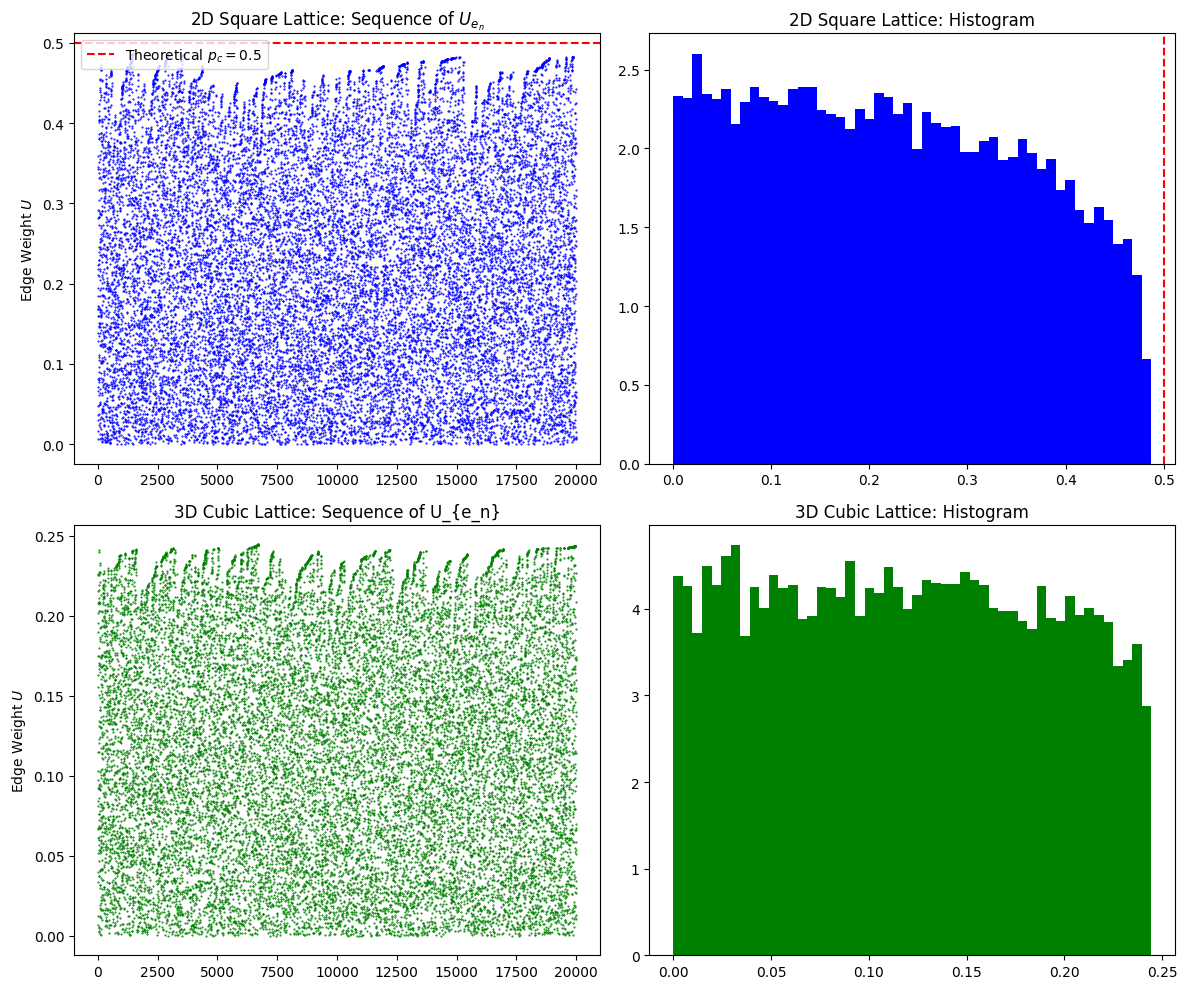

Estimated p_c for L^2: 0.4768
Estimated p_c for L^3: 0.2417


In [14]:
N_STEPS = 20000
u_seq_2d = run_invasion(dim=2, n_steps=N_STEPS)
u_seq_3d = run_invasion(dim=3, n_steps=N_STEPS)

fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].plot(u_seq_2d, '.', markersize=1, color='blue')
axs[0, 0].set_title(r"2D Square Lattice: Sequence of $U_{e_n}$")
axs[0, 0].set_ylabel("Edge Weight $U$")
axs[0, 0].axhline(y=0.5, color='r', linestyle='--', label=f'Theoretical $p_c=0.5$')
axs[0, 0].legend()

axs[0, 1].hist(u_seq_2d, bins=50, density=True, color='blue')
axs[0, 1].set_title("2D Square Lattice: Histogram")
axs[0, 1].axvline(x=0.5, color='r', linestyle='--')

axs[1, 0].plot(u_seq_3d, '.', markersize=1, color='green')
axs[1, 0].set_title(r"3D Cubic Lattice: Sequence of U_{e_n}")
axs[1, 0].set_ylabel("Edge Weight $U$")

axs[1, 1].hist(u_seq_3d, bins=50, density=True, color='green')
axs[1, 1].set_title("3D Cubic Lattice: Histogram")

plt.tight_layout()
plt.show()

# Estimates (using 99th percentile of the last 50% of data to avoid initial noise)
est_2d = np.percentile(u_seq_2d[N_STEPS//2:], 99)
est_3d = np.percentile(u_seq_3d[N_STEPS//2:], 99)

print(f"Estimated p_c for L^2: {est_2d:.4f}")
print(f"Estimated p_c for L^3: {est_3d:.4f}")

The invasion process greedily selects the edge with the minimum weight $U_e$ on the boundary. In the subcritical phase $p < p_c$, if the process is currently exploring a region with small $U$, then it stays there. In the supercritical phase $p > p_c$, if the process is forced to pick a large $U$ to escape a local trap, then it will do so, but only until it finds a connection back to the infinite cluster of small $U$ edges.

As $n$ becomes large, the process spends the vast majority of its time in the infinite cluster, which is characterised by edges with weights $U_e \lesssim p_c$. It will rarely, need to select an edge with $U_e$ significantly larger than $p_c$.

By plotting the histogram of the sequence $U_{e_n}$, we see a uniform distribution of values that abruptly cuts off at $p_c$. The maximum values in the tail of the sequence provide a good estimate for $p_c$.

For the square lattice $\mathbb{L}^2$, $p_c \approx 0.50$ which agrees with the known theoretical result $p_c = 1/2$. For the cubic lattice $\mathbb{L}^3$, $p_c \approx 0.25$ which is significantly lower. In three dimensions, each node has $6$ neighbours verses $4$ in two dimensions. With more options to find an open path, the individual edges do not need to be open as often for an infinite cluster to form. The accepted literature value is $p_c \approx 0.2488$.

---

We want to estimate $\theta_p = P(0 \leftrightarrow \infty)$ in a $p$-open graph simultaneously for all $p \in [0, 1]$. The invasion process generates a sequence of edge weights $U_{e_1}, U_{e_2}, \dots, U_{e_n}$ corresponding to the path of least resistance starting from the origin. Consider a specific probability threshold $p$.

*   If the origin is part of an infinite $p$-open cluster, then there exists a path of infinite length starting from the origin consisting entirely of edges with weights $U < p$. Because the invasion process greedily selects the smallest available weights, it will find and follow this path (or a similar one) and will essentially never be forced to cross an edge with weight $U \geq p$. The maximum weight encountered in the invasion sequence, $M_n = \max(U_{e_1}, \dots, U_{e_n})$, will be less than $p$.

*   If the origin is part of a finite $p$-open cluster, then the invasion process will fill this finite cluster. To continue beyond the cluster's boundary, it must eventually cross a closed edge with weight $U \geq p$. The maximum weight encountered in the invasion process will be at least $p$, i.e., $M_n \geq p$.

For a single simulation run of $n$ steps, we can define an indicator for whether the origin percolates at probability $p$
\begin{equation}
    \hat{I}_p =
    \begin{cases}
        1 & p > \max(U_{e_1}, \dots, U_{e_n}), \\
        0 & p \leq \max(U_{e_1}, \dots, U_{e_n}).
    \end{cases}
\end{equation}
To estimate the probability $\theta_p$, we perform this simulation $K$ times and average the results using the law of large numbers
\begin{equation}
    \hat{\theta}_p \approx \frac{1}{K} \sum_{k=1}^{K} \hat{I}_p^{(k)}.
\end{equation}
This is the cumulative distribution function (CDF) of the random variable $M_n = \max(U_{e_1}, \dots, U_{e_n})$ over the $K$ trials.

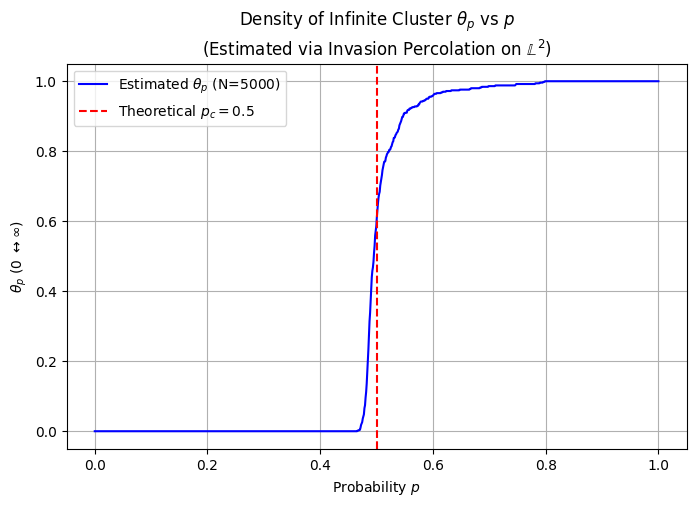

In [18]:
import heapq
import random
import matplotlib.pyplot as plt
import numpy as np

def run_max_weight_simulation(n_steps):
    invaded = set()
    start_node = (0, 0)
    invaded.add(start_node)
    boundary_pq = []

    # Initial neighbors
    directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
    for d in directions:
        neighbor = (start_node[0] + d[0], start_node[1] + d[1])
        heapq.heappush(boundary_pq, (random.random(), neighbor))

    current_max = 0.0

    # We only need to track the global maximum weight encountered
    for _ in range(n_steps):
        if not boundary_pq: break

        # Get smallest edge
        w, target = heapq.heappop(boundary_pq)

        if target in invaded:
            continue

        # Update invasion state
        invaded.add(target)
        if w > current_max:
            current_max = w

        # Add new neighbors
        for d in directions:
            neighbor = (target[0] + d[0], target[1] + d[1])
            if neighbor not in invaded:
                heapq.heappush(boundary_pq, (random.random(), neighbor))

    return current_max

N_STEPS = 5000
N_TRIALS = 500
max_weights = []

for i in range(N_TRIALS):
    mx = run_max_weight_simulation(N_STEPS)
    max_weights.append(mx)

max_weights.sort()
p_values = np.linspace(0, 1, 1000)
theta_estimates = []

for p in p_values:
    count = np.searchsorted(max_weights, p, side='left')
    theta_estimates.append(count / N_TRIALS)

plt.figure(figsize=(8, 5))
plt.plot(p_values, theta_estimates, 'b-', label=f'Estimated $\\theta_p$ (N={N_STEPS})')
plt.axvline(x=0.5, color='r', linestyle='--', label='Theoretical $p_c = 0.5$')
plt.title(f"Density of Infinite Cluster $\\theta_p$ vs $p$\n(Estimated via Invasion Percolation on $\\mathbb{{L}}^2$)")
plt.xlabel("Probability $p$")
plt.ylabel("$\\theta_p$ (0 $\\leftrightarrow \\infty$)")
plt.legend()
plt.grid(True)
plt.show()

The plot will be most inaccurate in the region immediately surrounding the critical probability $p \approx p_c = 0.5$. This is due to the fact that $n$ is finite.

1.  Overestimation near $p_c$ the subcritical tail:
    For $p$ slightly less than $p_c$, there are no infinite clusters, so $\theta_p$ should be exactly 0. However, at this range, the correlation length (the typical size of finite clusters) becomes very large. It is statistically possible for the origin to be in a large finite cluster at the terminal $n$ as it has not reached the boundary.

2.  Smearing of the phase transition:
    In an infinite system, the derivative of $\theta_p$ is infinite at $p_c$. With finite $n$, this transition is smoothed out and lacks the perfectly sharp kink that the theory predicts.

3.  Low $p$ regions:
    For very small $p$, the origin is surrounded by edges with random weights. The immediate neighbors might all have larger $p$ and the simulation correctly identifies this immediately. The inaccuracy is minimal here.